<a href="https://colab.research.google.com/github/priyakumari55/DEEP-LEARNING/blob/main/MOVIE_REVIEW_SENTIMENT_ANALYSIS_LSTM_AND__CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import numpy as np 
import pandas as pd 
import nltk
import gc
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt

In [82]:
train=pd.read_csv('train[1].tsv',sep='\t')
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [83]:
test=pd.read_csv('test[1].tsv',sep='\t')
print(test.shape)
test.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [84]:
test['Sentiment']=-999
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,-999
1,156062,8545,An intermittently pleasing but mostly routine ...,-999
2,156063,8545,An,-999
3,156064,8545,intermittently pleasing but mostly routine effort,-999
4,156065,8545,intermittently pleasing but mostly routine,-999


In [85]:
df=pd.concat([train,test],ignore_index=True)
print(df.shape)
df.tail()

(222352, 4)


,PhraseId,SentenceId,Phrase,Sentiment
222347,222348,11855,"A long-winded , predictable scenario .",-999
222348,222349,11855,"A long-winded , predictable scenario",-999
222349,222350,11855,"A long-winded ,",-999
222350,222351,11855,A long-winded,-999
222351,222352,11855,predictable scenario,-999


In [86]:
del train,test
gc.collect()

79869

In [87]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re

In [88]:
import string
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def clean_review(text):
    text = text.lower()
    text = re.sub(r"[-()\"#/@;:<>{}+=~|.?,]", "", text)
    review_lemma=[]
    for word in text.split():
        word_lemma = wordnet_lemmatizer.lemmatize(word)
        review_lemma.append(word_lemma)
    review_lemma=' '.join(review_lemma)
    return review_lemma

In [40]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
df['clean_review']=df['Phrase'].apply(clean_review)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,A series of escapades demonstrating the adage ...,1,a series of escapade demonstrating the adage t...
1,2,1,A series of escapades demonstrating the adage ...,2,a series of escapade demonstrating the adage t...
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


In [41]:
df_train=df[df.Sentiment!=-999]
df_train.shape

(156060, 5)

In [42]:
df_test=df[df.Sentiment==-999]
df_test.drop('Sentiment',axis=1,inplace=True)
print(df_test.shape)
df_test.head()

(66292, 4)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PhraseId,SentenceId,Phrase,clean_review
156060,156061,8545,An intermittently pleasing but mostly routine ...,an intermittently pleasing but mostly routine ...
156061,156062,8545,An intermittently pleasing but mostly routine ...,an intermittently pleasing but mostly routine ...
156062,156063,8545,An,an
156063,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing but mostly routine effort
156064,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing but mostly routine


In [43]:
del df
gc.collect()

524

In [44]:
train_text=df_train.clean_review.values
test_text=df_test.clean_review.values
target=df_train.Sentiment.values
y=to_categorical(target)
print(train_text.shape,target.shape,y.shape)

(156060,) (156060,) (156060, 5)


In [46]:
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(124848,) (124848, 5)
(31212,) (31212, 5)


In [47]:
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

15065

In [48]:
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

49

In [49]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 128
epochs = 10
num_classes=5

In [50]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(test_text)

In [51]:
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 49) (31212, 49) (66292, 49)


In [52]:
model1=Sequential()
model1.add(Embedding(max_features,100,mask_zero=True))
model1.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model1.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model1.add(Dense(num_classes,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1506500   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 1,561,321
Trainable params: 1,561,321
Non-trainable params: 0
_________________________________________________________________


In [53]:
%%time
history1=model1.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/10
976/976 [==============================] - 288s 296ms/step - loss: 1.0583 - accuracy: 0.5834 - val_loss: 0.8637 - val_accuracy: 0.6487
Epoch 2/10
976/976 [==============================] - 289s 296ms/step - loss: 0.8123 - accuracy: 0.6676 - val_loss: 0.8236 - val_accuracy: 0.6666
Epoch 3/10
976/976 [==============================] - 288s 295ms/step - loss: 0.7495 - accuracy: 0.6914 - val_loss: 0.8191 - val_accuracy: 0.6671
Epoch 4/10
976/976 [==============================] - 290s 297ms/step - loss: 0.7104 - accuracy: 0.7065 - val_loss: 0.8187 - val_accuracy: 0.6688
Epoch 5/10
976/976 [==============================] - 296s 303ms/step - loss: 0.6815 - accuracy: 0.7172 - val_loss: 0.8310 - val_accuracy: 0.6655
Epoch 6/10
976/976 [==============================] - 291s 298ms/step - loss: 0.6559 - accuracy: 0.7269 - val_loss: 0.8358 - val_accuracy: 0.6672
Epoch 7/10
976/976 [==============================] - 296s 303ms/step - loss: 0.6373 - accuracy: 0.7341 - val_loss: 0.8453 -

In [57]:
y_pred1=model1.predict_classes(X_test,verbose=1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
2072/2072 [==============================] - 40s 19ms/step


In [54]:
def plot_learningCurve(history,epoch):
  epoch_range=range(1,epoch+1)
  plt.plot(epoch_range,history.history['accuracy'])
  plt.plot(epoch_range,history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

  plt.plot(epoch_range,history.history['loss'])
  plt.plot(epoch_range,history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

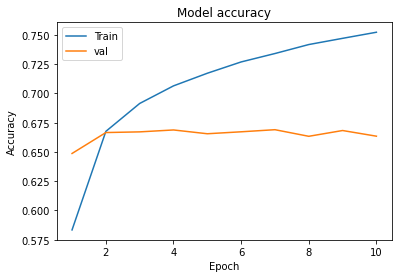

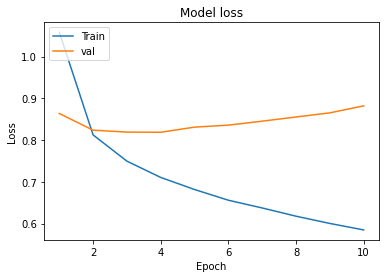

In [56]:
plot_learningCurve(history1,epochs)

**2.CNN**

In [60]:
model2= Sequential()
model2.add(Embedding(max_features,100,input_length=max_words))
model2.add(Dropout(0.2))

model2.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model2.add(GlobalMaxPooling1D())

model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(num_classes,activation='softmax'))


model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 49, 100)           1506500   
_________________________________________________________________
dropout (Dropout)            (None, 49, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 49, 64)            19264     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [61]:
%%time
history2=model2.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/10
976/976 [==============================] - 46s 47ms/step - loss: 1.0081 - accuracy: 0.5976 - val_loss: 0.8688 - val_accuracy: 0.6501
Epoch 2/10
976/976 [==============================] - 46s 47ms/step - loss: 0.7805 - accuracy: 0.6789 - val_loss: 0.8173 - val_accuracy: 0.6624
Epoch 3/10
976/976 [==============================] - 46s 47ms/step - loss: 0.6962 - accuracy: 0.7097 - val_loss: 0.8059 - val_accuracy: 0.6673
Epoch 4/10
976/976 [==============================] - 46s 47ms/step - loss: 0.6390 - accuracy: 0.7326 - val_loss: 0.8222 - val_accuracy: 0.6648
Epoch 5/10
976/976 [==============================] - 46s 47ms/step - loss: 0.5940 - accuracy: 0.7486 - val_loss: 0.8453 - val_accuracy: 0.6616
Epoch 6/10
976/976 [==============================] - 46s 47ms/step - loss: 0.5604 - accuracy: 0.7629 - val_loss: 0.8864 - val_accuracy: 0.6680
Epoch 7/10
976/976 [==============================] - 46s 47ms/step - loss: 0.5277 - accuracy: 0.7753 - val_loss: 0.9390 - val_accuracy:

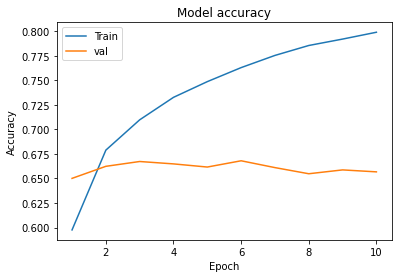

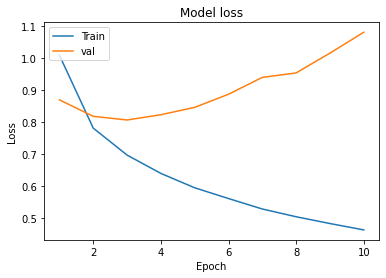

In [62]:
plot_learningCurve(history2,epochs)